## Import Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import os
from PIL import Image
from torch.nn.functional import log_softmax

torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

## Utils/Functions

In [ ]:
class basic_fcn(nn.Module):
    def __init__(self, ipchn=3, padd=1, n_class=21, initial_conv_padd=100, mpstride=2):
        super().__init__()
        
        #*************************** Econder Layers ***************************# 
        # Convolution layer 1
        self.conv1_1 = nn.Conv2d(ipchn, 32, 3, padding=initial_conv_padd)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=padd)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=mpstride, ceil_mode=True)  # 1/2

        # Convolution layer 2
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=padd)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=padd)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=mpstride, ceil_mode=True)  # 1/4

        # Convolution layer 3
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=padd)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=padd)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(128, 128, 3, padding=padd)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=mpstride, ceil_mode=True)  # 1/8

        # Convolution layer 4
        self.conv4_1 = nn.Conv2d(128, 256, 3, padding=padd)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(256, 256, 3, padding=padd)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(256, 256, 3, padding=padd)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=mpstride, ceil_mode=True)  # 1/16

        # Convolution layer 5
        self.conv5_1 = nn.Conv2d(256, 256, 3, padding=padd)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(256, 256, 3, padding=padd)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(256, 256, 3, padding=padd)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=mpstride, ceil_mode=True)  # 1/32

        # Fully Connected Layer 1, Total Layer 6
        self.fc6 = nn.Conv2d(256, 512, 3)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # Fully Connected Layer 2, Total Layer 7
        self.fc7 = nn.Conv2d(512, 1024, 3)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        #*************************** Decoder Layers ***************************#
        self.relu    = nn.ReLU(inplace=True)
        self.deconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=1)
        self.deconv5 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1)
        self.deconv4 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, dilation=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=4)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=2)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, dilation=1)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1, padding=1)



    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        out4 =h
 
        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)
        out5 = h

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)
        out6 = h

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.relu(self.deconv6(h))               
        h = h + out6 
        h = self.relu(self.deconv5(h))
        h = h + out5
        h = self.relu(self.deconv4(h))
        h = h + out4
        h = self.relu(self.deconv3(h))
        h = self.relu(self.deconv2(h))
        h = self.relu(self.deconv1(h))
        h = self.classifier(h)           

        return h


def validate_seg_model(epoch, model, val_loader, n_class, iu_scores, pixel_scores):
    model.eval()
    total_pixels = 0
    correct_pixels = 0
    iou_per_class = np.zeros(n_class)
    iou_counts = np.zeros(n_class)

    with torch.no_grad():
        for batch in val_loader:
            images = batch[0].cuda()
            true_masks = batch[1].cuda()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for cls in range(n_class):
                pred_inds = (preds == cls)
                target_inds = (true_masks == cls)

                intersection = (pred_inds & target_inds).sum().item()
                union = (pred_inds | target_inds).sum().item()

                if union > 0:
                    iou_per_class[cls] += intersection / union
                    iou_counts[cls] += 1

            correct_pixels += (preds == true_masks).sum().item()
            total_pixels += torch.numel(true_masks)

    mean_iou = (iou_per_class / np.maximum(iou_counts, 1)).mean()
    pixel_accuracy = correct_pixels / total_pixels

    iu_scores[epoch, :] = iou_per_class / np.maximum(iou_counts, 1)
    pixel_scores[epoch] = pixel_accuracy

    print(f"[Validation Epoch {epoch}] Pixel Accuracy: {pixel_accuracy:.4f} | Mean IoU: {mean_iou:.4f}")



def seg_train(model,epochs,train_loader,val_loader,optimizer,criterion,n_class):
    model.train()
    loss_track=[]
    iu_scores    = np.zeros((epochs, n_class))
    pixel_scores = np.zeros(epochs)

    for epoch in range(epochs):
        loss_train=0.0
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            inputs = batch[0].cuda()
            labels = batch[1].cuda()

            outputs = model(inputs)
            #outputs = log_softmax(outputs, dim=1)
            #outputs = torch.argmax(outputs, dim=1).to(torch.float32)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        loss_track.append(loss_train/iter)
        if epoch ==0 or epoch % 2 == 0:
            print("epoch{}, loss: {}".format(epoch, loss_train/iter))

        validate_seg_model(epoch, model, val_loader, n_class, iu_scores, pixel_scores)
        
    return loss_track,iu_scores,pixel_scores


class voc_data_load(torch.utils.data.Dataset):
    def __init__(self,rootpath,folder_data,folder_mask,filelist,n_class,colormap,download=0):
        
        if download==1:
            input_transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
            train_dataset = torchvision.datasets.VOCSegmentation(
                root=rootpath,
                year='2012',
                image_set='train',
                download=True,
                transform=input_transforms
            )

        self.img_folder = folder_data
        self.seg_folder = folder_mask
        self.img_list = os.listdir(folder_data)
        self.seg_list = os.listdir(folder_mask)
        self.transform = transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
        
        self.filelist = filelist
        self.n_class = n_class
        self.colormap = colormap
    
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img = Image.open(self.img_folder + "/" + self.filelist[idx] + ".jpg").convert('RGB')
        img = self.transform(img)
        
        seg = Image.open(self.seg_folder + "/" + self.filelist[idx] + ".png").convert("RGB")

        seg = seg.resize((256, 256), Image.NEAREST)
        seg = np.array(seg)
        segmentation_mask = np.zeros((256, 256, len(self.colormap)), dtype=np.float32)
        for label_index, label in enumerate(self.colormap):
            segmentation_mask[:, :, label_index] = np.all(seg == label, axis=-1).astype(float)
        segmentation_mask = np.transpose(segmentation_mask,(2,0,1))
        segmentation_mask = torch.from_numpy(segmentation_mask)
        segmentation_mask = segmentation_mask.argmax(dim=0).squeeze().long()

        return img, segmentation_mask
    

label_name = ["background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair", "cow", "dining table",
              "dog", "horse", "motorbike", "person", "potted plant",
              "sheep", "sofa", "train", "tv/monitor"]

label_color = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
               [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
               [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
               [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
               [0, 192, 0], [128, 192, 0], [0, 64, 128]
               ]    


## Load Data and Display Sample

In [3]:
##Load Training Data
n_class=21
rootpath = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data"
trainpath = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
readfunc = open(trainpath, "r").read().split('\n')
readfunc = readfunc[:1464]
original_images = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/JPEGImages"
segmentation_mask = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/SegmentationClass"
traindataset = voc_data_load(rootpath,original_images,segmentation_mask,readfunc,n_class,label_color)
train_loader = DataLoader(traindataset, batch_size=8, shuffle=True, num_workers=16)


##Load Validation Data
valpath = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
readfunc = open(valpath, "r").read().split('\n')
readfunc = readfunc[:1449]
valdataset = voc_data_load(rootpath,original_images,segmentation_mask,readfunc,n_class,label_color)
val_loader = DataLoader(valdataset, batch_size=4, num_workers=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Dimension in a Batch: torch.Size([8, 3, 256, 256])
Seg Dimension in a Batch: torch.Size([8, 256, 256])
Label unique classes: tensor([ 0,  1,  3,  4, 10, 15, 16, 20])


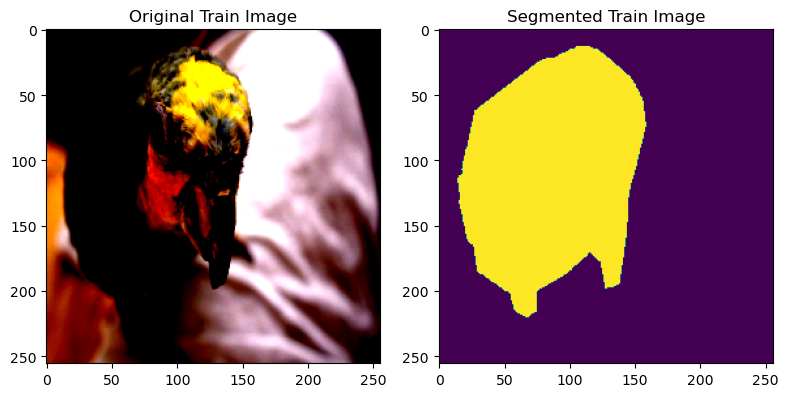

(array([ 0,  1,  3,  4, 10, 15, 16, 20]), array([433862,   2192,  20808,   2518,   3725,  20007,  13689,  27487]))


In [4]:
img, seg = next(iter(train_loader))

print('Image Dimension in a Batch:', img.shape)
print('Seg Dimension in a Batch:', seg.shape)
print("Label unique classes:", torch.unique(seg))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.transpose(img[1], (1, 2, 0)))
plt.title('Original Train Image')

plt.subplot(1,2,2)
plt.imshow(seg[1])
plt.title('Segmented Train Image')
plt.tight_layout()
plt.show()
print(np.unique(seg.numpy(), return_counts=True))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Dimension in a Batch: torch.Size([4, 3, 256, 256])
Seg Dimension in a Batch: torch.Size([4, 256, 256])
Label unique classes: tensor([ 0,  1,  4, 19])


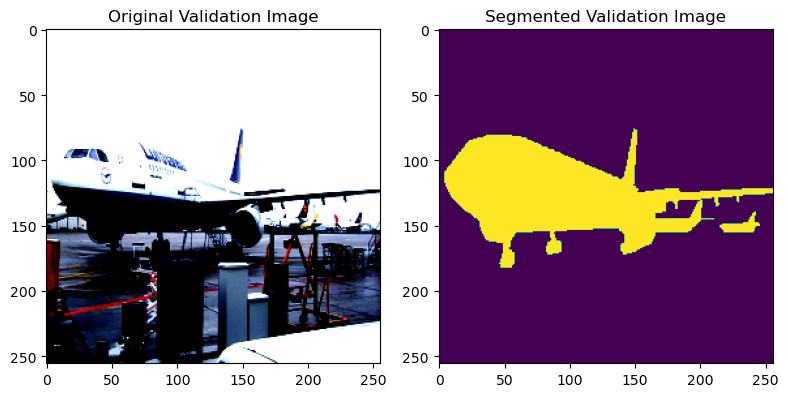

(array([ 0,  1,  4, 19]), array([184480,  11076,   4184,  62404]))


In [5]:
img, seg = next(iter(val_loader))

print('Image Dimension in a Batch:', img.shape)
print('Seg Dimension in a Batch:', seg.shape)
print("Label unique classes:", torch.unique(seg))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.transpose(img[0], (1, 2, 0)))
plt.title('Original Validation Image')

plt.subplot(1,2,2)
plt.imshow(seg[0])
plt.title('Segmented Validation Image')
plt.tight_layout()
plt.show()
print(np.unique(seg.numpy(), return_counts=True))

## Model Training

In [ ]:
## If Model is trained then load trained model and evaluate results. Else start a new training
model_path = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/models/basic_fcn_v0.pth"

if os.path.exists(model_path):
    fcn_model = basic_fcn().cuda()
    fcn_model.load_state_dict(model_path)
else:
    lr = 1e-4
    epochs = 250
    n_class = 21
    ipchn = 3
    momentum = 0.99
    w_decay = 1e-5

    fcn_model = basic_fcn().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fcn_model.parameters(), lr=lr)

    loss_track,iu_scores,pixel_scores = seg_train(fcn_model,epochs,train_loader,val_loader,optimizer,criterion,n_class)
    torch.save(fcn_model.state_dict(), "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/models/basic_fcn_v0.pth")

epoch0, loss: 1.9045457388018514
[Validation Epoch 0] Pixel Accuracy: 0.7195 | Mean IoU: 0.0344
[Validation Epoch 1] Pixel Accuracy: 0.7194 | Mean IoU: 0.0344
epoch2, loss: 1.3303997081059675
[Validation Epoch 2] Pixel Accuracy: 0.7194 | Mean IoU: 0.0344
[Validation Epoch 3] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
epoch4, loss: 1.3067137612091315
[Validation Epoch 4] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
[Validation Epoch 5] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
epoch6, loss: 1.3038957927908217
[Validation Epoch 6] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
[Validation Epoch 7] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
epoch8, loss: 1.292636275618941
[Validation Epoch 8] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
[Validation Epoch 9] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
epoch10, loss: 1.2907715344822013
[Validation Epoch 10] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
[Validation Epoch 11] Pixel Accuracy: 0.7194 | Mean IoU: 0.0343
epoch12, loss: 1.2654538534499786
[Validatio

## Plot Loss Function and Metrics

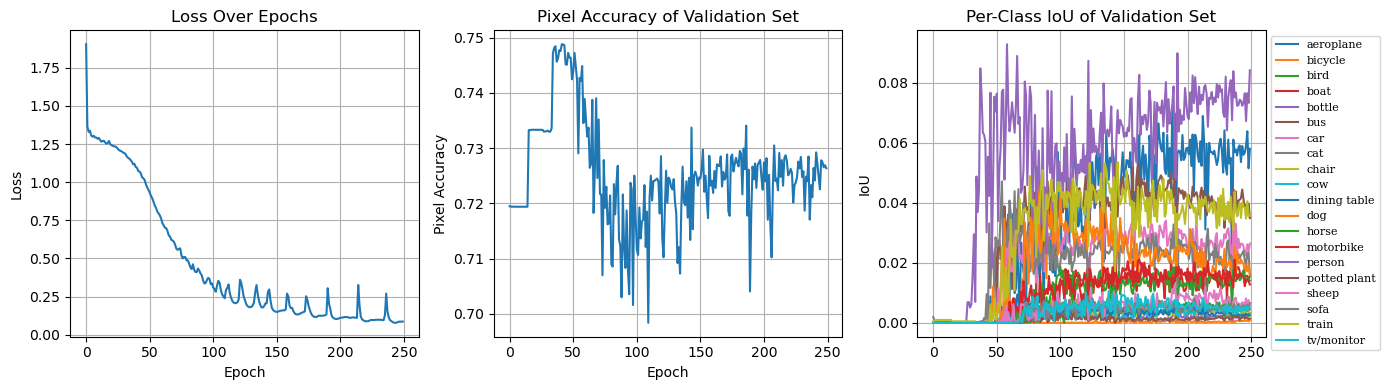

In [41]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(loss_track)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(pixel_scores)
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Pixel Accuracy of Validation Set')
plt.grid(True)

plt.subplot(1,3,3)
for cls in range(n_class-1):
    plt.plot(range(epochs), iu_scores[:, cls+1], label=label_name[cls+1])

plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Per-Class IoU of Validation Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.legend(prop={'size': 8, 'family': 'serif'}, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Validate Model and Visualize Results on Train Dataset

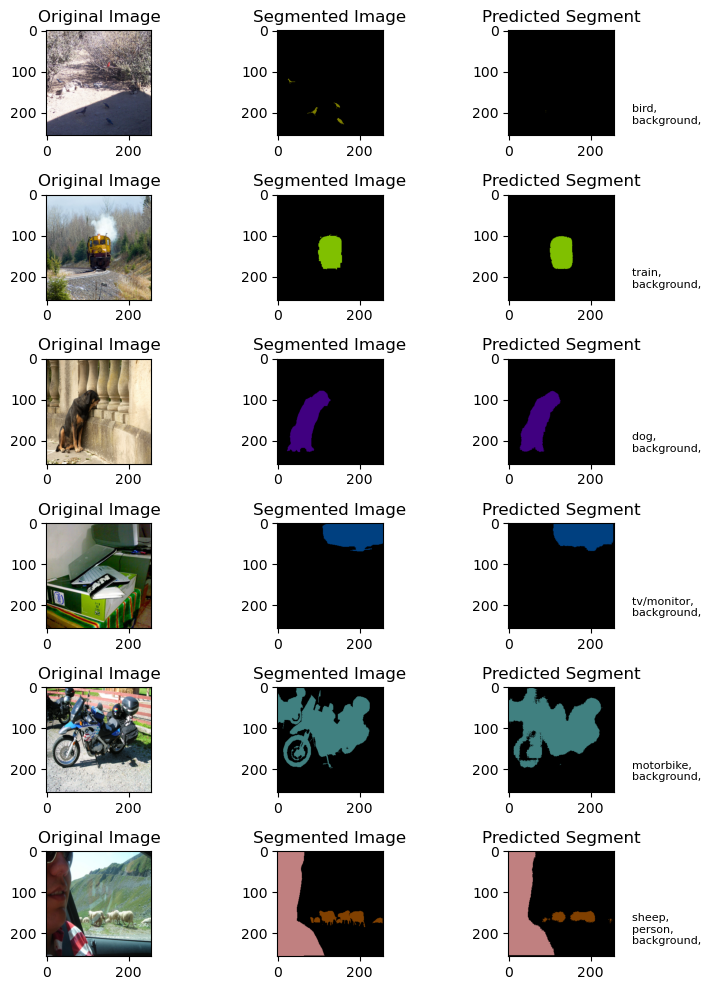

In [38]:
fcn_model.eval()
img, seg = next(iter(train_loader))

with torch.no_grad():
    out = fcn_model(img.cuda())
    plt_cnt=1
    plt.figure(figsize=(8,10))
    labelnames = []

    for idx in range(0,6):
        #print(out.shape)
        y_predict = out[idx].cpu().numpy()
        #print(y_predict.shape)
        y_predict = out[idx].argmax(dim=0).cpu().numpy()
        #print(y_predict.shape)

        labels_temp = ''
        for i in np.unique(y_predict).tolist():
            #print('Predcited label',label_name[i])
            labels_temp = label_name[i] + ', \n' + labels_temp

            color_mask = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask[seg[idx]==i] = np.array(color)
            
            color_mask_predict = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask_predict[y_predict==i] = np.array(color)
        labelnames.append(labels_temp)


        pltimg = np.transpose(img[idx],(1, 2, 0))
        mean=torch.tensor([0.485, 0.456, 0.406])
        std=torch.tensor([0.229, 0.224, 0.225])
        pltimg = std * pltimg + mean

        plt.subplot(6,3,plt_cnt)
        plt.imshow(np.clip(pltimg.numpy(),0,1))
        plt.title('Original Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask.astype(np.int32))
        plt.title('Segmented Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask_predict.astype(np.int32))
        plt.text(300,255,labelnames[idx],fontsize=8)
        plt.title('Predicted Segment')
        plt_cnt+=1


    plt.tight_layout()
    plt.show()

## Validate Model and Visualize Results on Validation Dataset

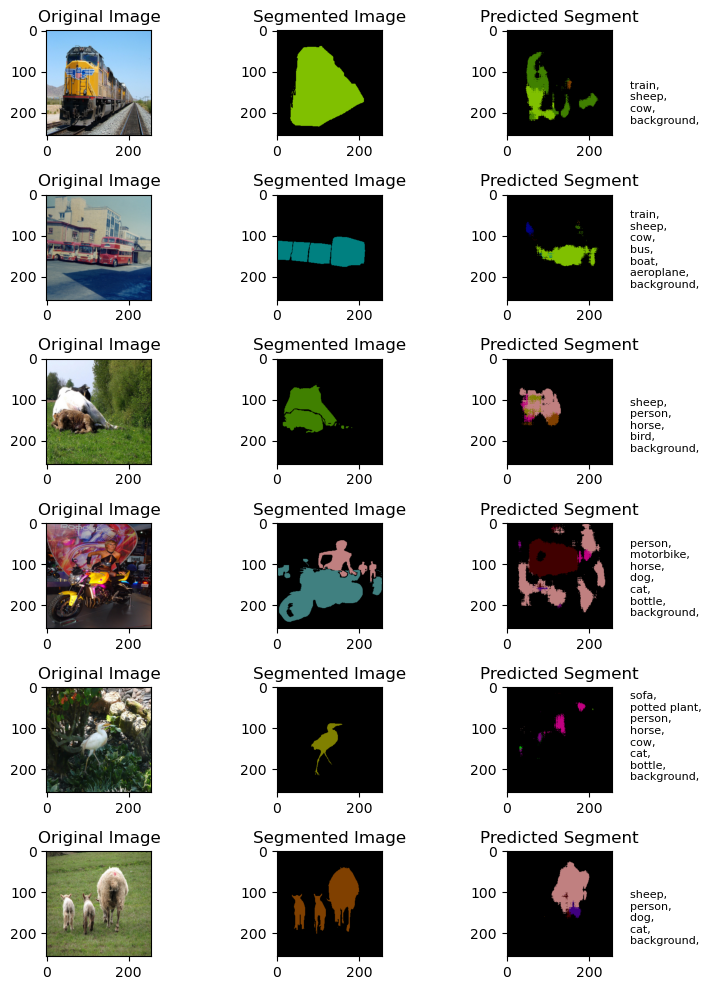

In [42]:
fcn_model.eval()
val_loader = DataLoader(valdataset, batch_size=6, num_workers=16, shuffle=True)
img, seg = next(iter(val_loader))

with torch.no_grad():
    out = fcn_model(img.cuda())
    plt_cnt=1
    plt.figure(figsize=(8,10))
    labelnames = []

    for idx in range(0,6):
        #print(out.shape)
        y_predict = out[idx].cpu().numpy()
        #print(y_predict.shape)
        y_predict = out[idx].argmax(dim=0).cpu().numpy()
        #print(y_predict.shape)

        labels_temp = ''
        for i in np.unique(y_predict).tolist():
            #print('Predcited label',label_name[i])
            labels_temp = label_name[i] + ', \n' + labels_temp

            color_mask = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask[seg[idx]==i] = np.array(color)
            
            color_mask_predict = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask_predict[y_predict==i] = np.array(color)
        labelnames.append(labels_temp)


        pltimg = np.transpose(img[idx],(1, 2, 0))
        mean=torch.tensor([0.485, 0.456, 0.406])
        std=torch.tensor([0.229, 0.224, 0.225])
        pltimg = std * pltimg + mean

        plt.subplot(6,3,plt_cnt)
        plt.imshow(np.clip(pltimg.numpy(),0,1))
        plt.title('Original Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask.astype(np.int32))
        plt.title('Segmented Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask_predict.astype(np.int32))
        plt.text(300,255,labelnames[idx],fontsize=8)
        plt.title('Predicted Segment')
        plt_cnt+=1


    plt.tight_layout()
    plt.show()

### Test Codes

In [ ]:
# print(out.min(), out.max(), out.mean(),out.shape)
# print(np.unique(seg.numpy(), return_counts=True))
# print(img.shape,seg.shape,out.shape,preds.shape)
# print(np.unique(seg.numpy(), return_counts=True))

# for i in range(0,21):
#     print(out[1,i].max())

#out = out[0]
#preds = torch.argmax(out[0], dim=0)

# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# plt.imshow(np.transpose(img[1], (1, 2, 0)))
# plt.title('Original Image')
# plt.subplot(1,3,2)
# plt.imshow(seg[1])
# plt.title('Original Masked Image')
# plt.subplot(1,3,3)
# plt.imshow(preds.detach().cpu())
# plt.title('Predicted Masked Image')

#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.RMSprop(fcn_model.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)

##seg = self.mask_transforms(seg)
#seg = seg.resize((256,256), resample=Image.NEAREST)
#seg = np.array(seg).astype(np.int64)
#seg[seg == 255] = 255
#seg = torch.from_numpy(seg).long()
#seg = seg.squeeze(0)

# self.mask_transforms = transforms.Compose([
#                         transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
#                         transforms.ToTensor()])

#### Reference Links
- https://debuggercafe.com/semantic-segmentation-using-pytorch-fcn-resnet/ 
- https://www.kaggle.com/code/datnguyen1235/pascal-voc-with-resunet-pytorch
- https://www.kaggle.com/code/xixihaha318/sematicsegmentation-with-pytorch
- https://github.com/initiativealmendra/DL-architectures/blob/master/FCN.py
- https://github.com/wkentaro/pytorch-fcn/blob/main/examples/voc/train_fcn16s.py
- https://github.com/pochih/FCN-pytorch/blob/master/python/train.py
- https://www.kaggle.com/code/mrinath/segmentation-baseline
- https://github.com/LaurentVeyssier/Semantic-Segmentation-with-Fully-Convolution-Network?tab=readme-ov-file